# Overlapping Generations Heterogenous Agents Model (OLGHA)

This notebook presents and solves a simple overlapping generations heterogenous agents model.

# The Model

## Demographics

Let $N_{i,t}$ denote the number of agents of age $i$ in period $t$. 
Total population is given by $N_t = \sum_i N_{i,t}$. 
Each period, $1+n$ households of age 0 are born. 
Subsequently, households face stochastic survival rates $\phi_{i-1,i}$ for $i\geq1$. 
These compound to $\Phi_{i}=\prod_{k=1}^{i}\phi_{k-1,k}$. 
By definition, $\phi_{T,T+1}=0$.

Assuming there is one zero-year old at date $t=0$, the population of each age at time t is:

\begin{eqnarray}
N_{0t} &=& \left(1+n\right)^{t},\\
N_{it}&=&\Phi_{i}\left(1+n\right)^{t-i}.
\end{eqnarray}

Total population $N_{t}$ is growing at the rate of entrants:

$$N_{t}=\sum_{i=0}^{T}N_{it}=\left(1+n\right)^{t}\sum_{i=0}^{T}\frac{\Phi_{i}}{\left(1+n\right)^{i}}.$$

We can write population shares $\pi_{i}=\frac{N_{it}}{N_{t}}$, then $\pi_{i}=\frac{\Phi_{i}}{\left(1+n\right)^{i}}\pi_{0}$ where $\pi_{0}=\left[\sum_{i=0}^{T}\frac{\Phi_{i}}{\left(1+n\right)^{i}}\right]^{-1}$.

## Households

Households enter economic life and start working at age $T^{w}$, they retire at age $T^{r}$, and die for sure at age $T$.
They maximize lifetime utility

$$ \sum_{i=T^{w}}^{T}\beta^{i}\Phi_{i}u\left(c_{i}\right), $$

where $\Phi_i$ is the probability of surviving up to age $i$. 
Agents are subject to the budget constraints

$$ c_i + a_{i+1} = \frac{1+r}{\phi_{i-1,i}} a_{i} + y_i. $$

Before retirement, households supply labor $\bar{h}$ inelastically and are subject to idiosyncratic productivity shocks $\varepsilon$ that follow a Markov chain. 
Once retired, households perceive social security benefits $d$. 
Income is then

$$y_{t,i} = \begin{cases} (1-\tau_t) w_t \bar{h}_i \varepsilon & i < T^{r} \\ d_t & i\ge T^{r} \end{cases}.$$

## Production

A unit measure of firms produce output with effective labor $L_t = \sum_{j}N_{t,j}\bar{h}_{j}$ and capital $K_t$ with technology

$$ Y_t = Z^{*} F(K_t, L_t) = Z^{*}  K_t^{\alpha} L_t^{1-\alpha}, $$

where $Z^{*}$ is a normalization constant to ensure $Y=1$ in steady-state. 

Perfect competition implies

\begin{eqnarray}
w_t &=& (1-\alpha) \left(\frac{K_t}{L_t}\right)^{\alpha},  \\
r_t &=& \alpha \left(\frac{K_t}{L_t}\right)^{\alpha-1} - \delta. \\
\end{eqnarray}

## Government

The government finances the social security benefits $d_t$ with a payroll tax $\tau_t$ such that

$$ \underbrace{\tau_t  \sum_{i=T^{w}}^{T^{r}-1} w_t N_{i,t}\bar{h}_{i}}_{Taxes} = \underbrace{\sum_{i=T^{r}}^{T} d_{t} N_{i,t}}_{Transfers} .$$

# General Equilibrium

Asset market clearing implies:

$$ \frac{K_t(r_t)}{N_t} = \frac{A_t(r_t)}{N_t}, $$

where $\frac{A_t(r_t)}{N_t}=\sum_{i=0}^{T}\pi_{it}a_{it}(r_t)$ and $\frac{K_t(r_t)}{N_t} = F_K^{-1}(r_t + \delta) \cdot \sum_{j}\pi_{t,j}\bar{h}_{j}$.

# Computation

## Backward iteration to get policies

The household problem is given by

\begin{eqnarray}
V(\varepsilon,a,i)&=&\max_{c_i,a_{i+1}}\frac{c_i^{1-\sigma}}{1-\sigma}+{\beta}\phi_{i,i+1}\mathbb{E}[V(\varepsilon',a',i+1)|\varepsilon] \\
\text{s.t.} && c_i + a_{i+1} = \frac{1+r}{\phi_{i-1,i}} a_{i} + y_i \\
&& a_{i+1} \ge \underline{a}
\end{eqnarray}

The Euler equation is

$$ c_i^{-\sigma}=\beta(1+r)\mathbb{E}\left[c_{i+1}^{-\sigma}\right]. $$

We can solve this problem with the method of endogenous grid points, iterating on the consumption policy function in the Euler equatiion above. 
Let's define cash-on-hand as, for a given asset grid $a$

$$ z_{i}\left(a,\varepsilon\right)={y_{i}}(\varepsilon)+\frac{\left(1+r\right)}{\phi_{i-1,i}}a. $$

For $i=T$, agents simply consume their cash-on-hand

$$ c_T = z_T(a, \varepsilon), \qquad a_T = 0. $$

We can then solve by backward recursion

$$ {c}\left(i,\varepsilon,{a}\right)^{-\sigma}={\beta}(1+r)\mathbb{E}\left[c\left(i+1,\varepsilon',a'\left(i,\varepsilon,{a}\right)\right)^{-\sigma}|\varepsilon\right] ,$$

using the method of endogenous grids: starting from the consumption policy at $i+1$ and any grid point $a'$, figure out consumption $c$ from the above equation, then assets $a$ from solving the budget constraint

$$ c +a' = z_{j}\left({a},\varepsilon\right). $$

This yields the inverse policy $a\left(a',\varepsilon,i\right)$, which can be inverted to get the direct policy $a'\left(a,\varepsilon,i\right)$.
If this yields $a'\left(a,\varepsilon,i\right)\le\underline{a}$ we replace the policy by $a'\left(a,\varepsilon,i\right)=-\underline{a}$. 

## Forward iterations to get distributions

Given a distribution of agents $D(\varepsilon,a, i)$, we obtain $D(\varepsilon',a', i+1)$ as 

$$D(\varepsilon',a', i+1) = \sum_\varepsilon D(\varepsilon,a'^{-1}\left(a,\varepsilon,i\right),i) \cdot \Pi(\varepsilon,\varepsilon'), $$

where $a'^{-1}\left(a,\varepsilon,i\right)$ is the inverse asset policy function.

First, we use the asset policy function to construct the distribution $D(\varepsilon,a',i)$.
* For $i=T^{w}$, we initialize this distribution with a mass point at $0$ since no agent holds any asset.
* Then, for each $(\varepsilon, a)$, we interpolate to find the $\lambda$ such that $ a'(\varepsilon, a, i) = \lambda a^1 + (1-\lambda)a^2$ where $a^1$ and $a^2$ are the closest grid points on both sides of $a'(\varepsilon, a, i)$.
* We then add $\lambda D(\varepsilon,a,i)$ to $D(\varepsilon,a^1,i)$ and $(1-\lambda) D(\varepsilon,a,i)$ to $D(\varepsilon,a^2,i)$.

Then, we use the Markov transition matrix $\Pi$ of $\varepsilon$ to go from $D(\varepsilon,a',i)$ to $D(\varepsilon',a',i+1)$.

## Aggregation

We can obtain aggregate variables simply by doing

$$ A = \sum N_{i} \cdot a'\left(a,\varepsilon,i\right) \cdot D(\varepsilon,a, i) $$


# Steady State

Let's now solve for the steady-state of the model. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt


from utils import set_parameters, make_path, pack_jacobians
from production import ss_production
from government import government
from household import household_ss_olg
from demographics import pop_stationary, trans_pop
from td import td_olg, get_Jacobian, td_GE_olg

First, we set the parameters of the model using set_parameters() and store them in a dictionnary named 'params'.
This functions defines the age structure, calculates the stationnary population distribution, defines production and preferences parameters, constructs the asset grid, and discretizes the idiosyncratic productivity shocks.

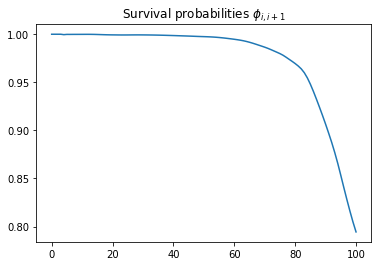

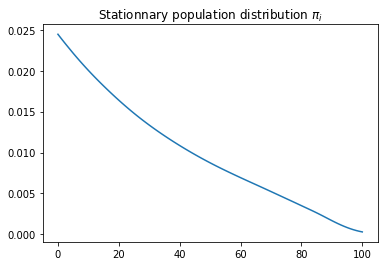

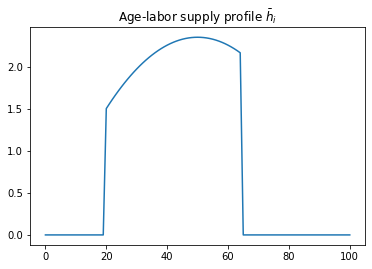

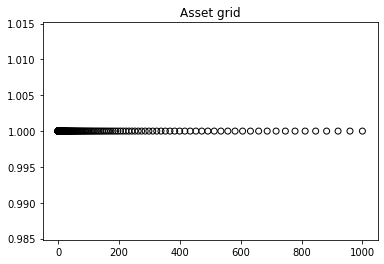

In [2]:
params = set_parameters()

plt.plot(params['phi'])
plt.title(r'Survival probabilities $\phi_{i,i+1}$')
plt.show()

plt.plot(params['pi'])
plt.title(r'Stationnary population distribution $\pi_i$')
plt.show()

plt.plot(params['h'])
plt.title(r'Age-labor supply profile $\bar{h}_i$')
plt.show()

plt.scatter(params['a'], np.ones_like(params['a']), facecolors='none', edgecolors='k')
plt.title('Asset grid')
plt.show()

Let's now compute the real wage and the capital-labor ratio implied by the parameters we just set.
Remember that given $r$. $\alpha$ and $\delta$ we can derive $K_t/L_t$ that we can use to get $w_t$. 
From $K_t/L_t$ we can obtain $K_t/N_t = K_t/L_t \cdot \sum_{j}\pi_{t,j}\bar{h}_{j}$.

In [3]:
w, K_L = ss_production(params['r'], params['alpha'], params['delta'])
K = K_L * params['workers']
print(f'Real wage: {w}')
print(f'K/L ratio: {K_L}')

Real wage: 1.1509986750018124
K/L ratio: 5.153725410455877


We can now choose the payroll tax rate and the social security benefits to clear the government's budget constraint.
We set $\tau=20\%$ and compute $d$ to balance the budget given the demographic structure:

$$ d_t = \tau_t w_t \frac{\sum_{i=T^{w}}^{T^{r}-1}\pi_{i,t}\bar{h}_{i}}{\sum_{i=T^{r}}^{T}  \pi_{i,t}} $$

In [4]:
tau, d = government(w, params['retirees'])
print(f'Payroll tax: {100*tau: .0f}%')
print(f'Benefits: {d: .2f}')

Payroll tax:  20%
Benefits:  2.09


We have now all the necessary inputs to solve the household's problem.
In equilibrium we want to have that asset supply equates asset demand, i.e. $A = K$. 
There are multiple ways to proceed.
Here we take as given a certain interest rate $r$ that implies a certain level of capital $K$.
We will then calibrate the subjective discount factor $\beta$ such that $A=K$. 
This allows us to choose the interest rate that clears the market.
Alternatively, we could fix $\beta$ and solve for the interest rate $r$.

In [5]:
def error(beta, K, params, w, tau, d):
    params['beta'] = beta
    return household_ss_olg(params, w, tau, d)['A'] - K

params['beta'] = opt.newton(error, x0=0.95, args=(K, params, w, tau, d))
print(f'Calibrated subjective discount factor : {params["beta"]: .2f}')

Calibrated subjective discount factor :  0.90


Let's now evaluate the equilibrium objects at this value of $\beta$ and visualize the equilibrium outcomes.

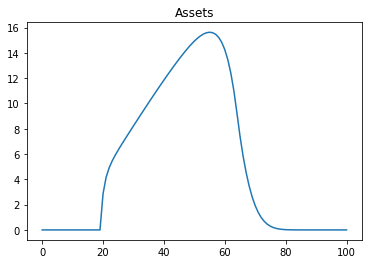

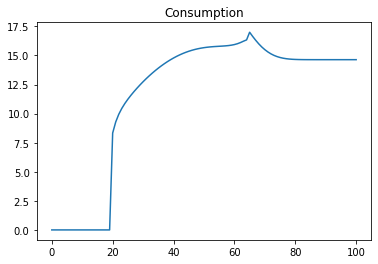

In [6]:
ss = household_ss_olg(params, w, tau, d)

plt.plot()
plt.title('Assets')
plt.plot(ss['A_j'])
plt.show()

plt.plot()
plt.title('Consumption')
plt.plot(ss['C_j'])
plt.show()

# Transitional Dynamcis

## Partial equilibrium 

Suppose that the population growth rate suddenly drops from 2% to 1%. 
Given the demographic structure above, and for a fixed $\phi$, we can simulate exactly the evolution of the population from the time of the shock until it reaches the new stationary distribution.

Let's visualize how is the stationary distribution affected.

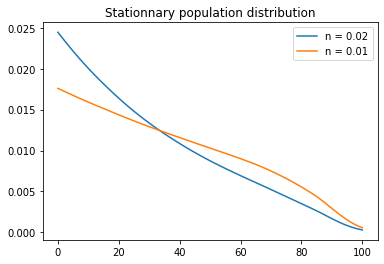

In [7]:
n_new = 0.01
pi_old = pop_stationary(params['n'], params['phi'], T=params['T'])
pi_new = pop_stationary(n_new, params['phi'], T=params['T'])

plt.plot(pi_old, label=f'n = {params["n"]}')
plt.plot(pi_new, label=f'n = {n_new}')
plt.legend()
plt.title('Stationnary population distribution')
plt.show()

Let's now simulation the evolution of the distribution for the first 100 years after the shock.

For later, we will need an additional $(T-T^{w})$ years to compute a full cross-section of agents in the 100 years of the transition.

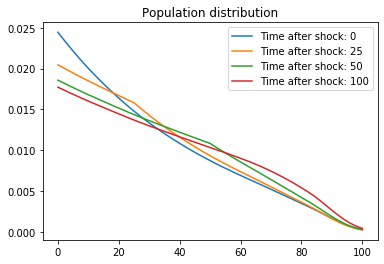

In [8]:
Ttrans = 100
Ttrans_full = Ttrans + params['T'] - params['Tw']
pi_trans = trans_pop(params['pi'], n_new, params['phi'], Ttrans=Ttrans_full)

for t in [0, 25, 50, 100]:
    plt.plot(pi_trans[t,:], label=f'Time after shock: {t}')
plt.legend()
plt.title('Population distribution')
plt.show()

Let's now compute the full transitional dynamics.
We first compute the partial equilibrium transition, that is, for a fixed interest rate $r_t = r_0, \forall t>0$.

We store the path of the interest rate and the initial steady-state distribution we obtained above. 
The path of the interest rate is stores as dict to make it easier to allow additional paths of inputs.

In [9]:
paths_trans = {'r':make_path(params['r'], Ttrans)}
D0 = ss['D']

Computing the transiton relies on the exact same procedure as to compute the steady-state: iterating backwards to get the policies, and forward to get the distributions.
We only need to be careful about the inputs into the household problem, e.g. $r_t$ varies with time, the government will need to adjust its budget in response to the demographic change, etc.

In [10]:
td_PE = td_olg(paths_trans, params, pi_trans, D0)

Total time: 2.29 sec


Let's visualize some outcomes along the transition.

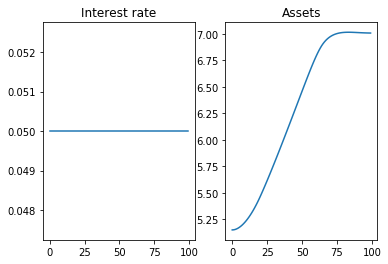

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(td_PE['r'])
ax1.set_title('Interest rate')
ax2.plot(td_PE['A'])
ax2.set_title('Assets')
plt.show()

## General equilibrium 

Suppose now that you want to solve for the general equilibrium along the transition, i.e. find $\mathbf{r}\equiv\{r_t\}$ such that $A_t=K_t$ for all $t$.

One efficient method of solving for the path $\mathbf{r}$ is Newton's method:

1. Starting from $j=0$, guess a path for the interest rate $\mathbf{r}^{0}$
2. Calculate the path of error in the asset market clearing condition: $\mathbf{H}(\mathbf{r})$
3. Update the guess according to $ \mathbf{U}^{j+1} = \mathbf{U}^{j} - \mathbf{U}_{\mathbf{r}}^{-1} \mathbf{r}^{j} $ where $\mathbf{U}_{\mathbf{r}}$ is the Jacobian. 

We first need to compute the Jacobian $\mathbf{U}_{\mathbf{r}}$. 
Every column of this matrix corresponds to the change in the error in the asset market clearing condition in response to a change in the interest rate at a different horizon.
It can be computed directly using automatic differentiation.

In [12]:
inputs, outcomes = ['r'], ['nad']
J = get_Jacobian(paths_trans, params, pi_trans, D0, inputs, outcomes)

# Pack into one matrix and export
H_X = pack_jacobians(J, inputs, outcomes, Ttrans)
# np.save('H_X.npy', H_X)  # Save it to maybe re-use later
# H_X = np.load('H_X.npy')

Total time: 4.13 sec
Total time: 2.86 sec
Total time: 2.48 sec
Total time: 2.31 sec
Total time: 2.62 sec
Total time: 2.30 sec
Total time: 2.33 sec
Total time: 2.01 sec
Total time: 2.44 sec
Total time: 2.42 sec
Total time: 2.04 sec
Total time: 2.32 sec
Total time: 2.15 sec
Total time: 2.15 sec
Total time: 2.12 sec
Total time: 2.31 sec
Total time: 1.95 sec
Total time: 2.04 sec
Total time: 2.08 sec
Total time: 2.07 sec
Total time: 1.95 sec
Total time: 3.12 sec
Total time: 3.10 sec
Total time: 2.90 sec
Total time: 2.62 sec
Total time: 2.88 sec
Total time: 3.04 sec
Total time: 2.34 sec
Total time: 1.96 sec
Total time: 2.03 sec
Total time: 1.87 sec
Total time: 1.84 sec
Total time: 2.17 sec
Total time: 2.00 sec
Total time: 2.23 sec
Total time: 2.36 sec
Total time: 2.15 sec
Total time: 2.16 sec
Total time: 2.16 sec
Total time: 2.30 sec
Total time: 2.45 sec
Total time: 2.29 sec
Total time: 2.31 sec
Total time: 2.33 sec
Total time: 2.54 sec
Total time: 2.23 sec
Total time: 3.17 sec
Total time: 2

We can now solve for the general equilibrium transition using Newton's method.

In [13]:
td_GE = td_GE_olg(H_X, paths_trans, params, pi_trans, D0, outcomes, inputs, disp=True)

Total time: 1.85 sec
On iteration 0
   max error for nad is 1.45E+00
Total time: 2.60 sec
On iteration 1
   max error for nad is 1.56E-02
Total time: 2.65 sec
On iteration 2
   max error for nad is 2.34E-04
Total time: 2.42 sec
On iteration 3
   max error for nad is 2.26E-05
Total time: 2.70 sec
On iteration 4
   max error for nad is 3.08E-06
Total time: 2.59 sec
On iteration 5
   max error for nad is 4.85E-07
Total time: 2.51 sec
On iteration 6
   max error for nad is 1.12E-07
Total time: 2.74 sec
On iteration 7
   max error for nad is 2.54E-08
Total time: 3.63 sec
On iteration 8
   max error for nad is 5.70E-09


Let's visualize some objects along the transition.

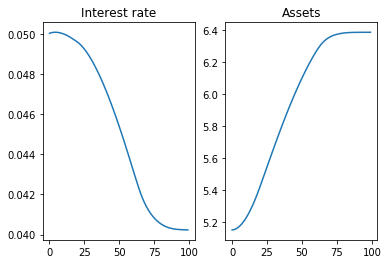

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(td_GE['r'])
ax1.set_title('Interest rate')
ax2.plot(td_GE['A'])
ax2.set_title('Assets')
plt.show()



